In [2]:
import itertools

import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as st
import xarray as xr

import neuro_op as nop

In [3]:
nop.plot_setup()

In [4]:
# Define util functions


def get_name(N_nodes, nn, sd_llf):
    return str(
        "../testing/@MA1-FirstBuilder/output2/"
        + "out"
        + "-N"
        + str(N_nodes)
        + "-nn"
        + str(nn)
        + "-sd_llf"
        + str(sd_llf)
        + ".h5"
    )


def get_mu(a, b, c):
    data = nop.import_hdf5(get_name(a, b, c), samples=True)
    return data["mu_nodes"]


def get_sd(a, b, c):
    data = nop.import_hdf5(get_name(a, b, c), samples=True)
    return data["sd_nodes"]


def get_kld(a, b, c):
    data = nop.import_hdf5(get_name(a, b, c), samples=True)
    return data["kl_divs"]


# Analytical functions for conjugate pairs


def sd_N(sd0, sd_in, N):
    """Returns analytically obtained sd of Normal conjugate pair after N data points with sd=sd_in"""
    return (sd0**-2 + N * sd_in**-2) ** -0.5


def KLD_PPD(mu1, mu2, sd1, sd2):
    """Returns analytically obatined KLD of two univariate Normal distributions"""
    return np.log(sd2 / sd1) + (sd1**2 + (mu1 - mu2) ** 2) / (2 * sd2**2) - 1 / 2


def get_ls(sd_llf):
    if sd_llf == 1:
        ls = "--"
    elif sd_llf < 1:
        ls = ":"
    else:
        ls = "-"
    return ls

In [30]:
# Define parameter ranges to be used in this analysis
N_nodes = 150
N_arr = [1, 2]
nn_arr = [0, 1]
sd_llf_arr = np.round(np.arange(0.5, 5.1, 0.5), 1)
sd_llf_arr = sd_llf_arr[[0, 1, 3, 5, 7, 9]]
t_arr = np.arange(0, len(get_kld(1, 0, sd_llf_arr[-1])), 1)
t2_len = len(get_kld(2, 1, sd_llf_arr[-1]))

In [31]:
# Initialize xarray Dataset

tmp_arr = np.empty((len(N_arr), len(nn_arr), len(sd_llf_arr), len(t_arr), N_nodes))
ds = xr.Dataset(
    {
        "mu": (("N", "nn", "sd_llf", "time", "node"), np.empty_like(tmp_arr)),
        "sd": (("N", "nn", "sd_llf", "time", "node"), np.empty_like(tmp_arr)),
        "kld": (("N", "nn", "sd_llf", "time", "node"), np.empty_like(tmp_arr)),
    },
    coords={
        "N": N_arr,
        "nn": nn_arr,
        "sd_llf": sd_llf_arr,
        "time": t_arr,
        "node": np.arange(N_nodes),
    },
)
del tmp_arr

# Populate the Dataset
for N, sd_llf in itertools.product(N_arr, sd_llf_arr):
    if N == 1:
        nn = 0
        ds.mu.loc[dict(N=N, nn=nn, sd_llf=sd_llf, node=np.arange(N_nodes))] = get_mu(
            N, nn, sd_llf
        )
        ds.sd.loc[dict(N=N, nn=nn, sd_llf=sd_llf, node=np.arange(N_nodes))] = get_sd(
            N, nn, sd_llf
        )
        ds.kld.loc[dict(N=N, nn=nn, sd_llf=sd_llf, node=np.arange(N_nodes))] = get_kld(
            N, nn, sd_llf
        )
    elif N == 2:
        nn = 1
        ds.mu.loc[
            dict(
                N=N, nn=nn, sd_llf=sd_llf, node=np.arange(N_nodes), time=t_arr[:t2_len]
            )
        ] = get_mu(N, nn, sd_llf)
        ds.sd.loc[
            dict(
                N=N, nn=nn, sd_llf=sd_llf, node=np.arange(N_nodes), time=t_arr[:t2_len]
            )
        ] = get_sd(N, nn, sd_llf)
        ds.kld.loc[
            dict(
                N=N, nn=nn, sd_llf=sd_llf, node=np.arange(N_nodes), time=t_arr[:t2_len]
            )
        ] = get_kld(N, nn, sd_llf)
    else:
        for nn in nn_arr[2:]:
            ds.mu.loc[dict(N=N, nn=nn, sd_llf=sd_llf, node=np.arange(N_nodes))] = (
                get_mu(N, nn, sd_llf)
            )
            ds.sd.loc[dict(N=N, nn=nn, sd_llf=sd_llf, node=np.arange(N_nodes))] = (
                get_sd(N, nn, sd_llf)
            )
            ds.kld.loc[dict(N=N, nn=nn, sd_llf=sd_llf, node=np.arange(N_nodes))] = (
                get_kld(N, nn, sd_llf)
            )
ds

<xarray.Dataset> Size: 864MB
Dimensions:  (N: 2, nn: 2, sd_llf: 6, time: 10001, node: 150)
Coordinates:
  * N        (N) int64 16B 1 2
  * nn       (nn) int64 16B 0 1
  * sd_llf   (sd_llf) float64 48B 0.5 1.0 2.0 3.0 4.0 5.0
  * time     (time) int64 80kB 0 1 2 3 4 5 6 ... 9995 9996 9997 9998 9999 10000
  * node     (node) int64 1kB 0 1 2 3 4 5 6 7 ... 143 144 145 146 147 148 149
Data variables:
    mu       (N, nn, sd_llf, time, node) float64 288MB 0.0 0.0 0.0 ... 0.0 0.0
    sd       (N, nn, sd_llf, time, node) float64 288MB 10.5 10.5 ... 0.0 0.0
    kld      (N, nn, sd_llf, time, node) float64 288MB 1.856 1.856 ... 0.0 0.0

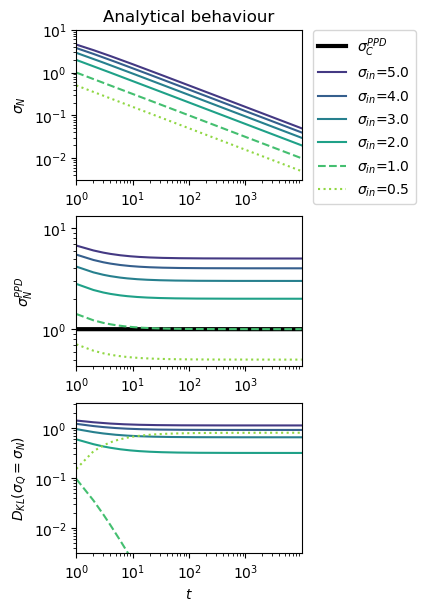

In [7]:
# How would we expect the KLD to develop, given different sd_in, sd0?

sd_arr = ds.sd_llf.values[::-1]  # Reverse to have line stacking match label stacking
sd0 = 10  # For analytical results, use the same prior as for simulations
sd_C = 1  # Central node PPD's sd
N = int(10**4)  # Also, use the same time span
time = np.arange(N)

# Plotting...
x = 1
y = 3
c = 2
fig, ax = plt.subplots(y, x, figsize=(1.5 * c * x, 1 * c * y))

# Preparation: Add line to-be-modelled PPD sd (aka. sd_PPD=1); set colorcycles
ax[1].plot(time, np.ones(N) * sd_C, color="black", lw=3, label="$\sigma^{PPD}_{C}$")
colors = nop.get_colorcycle(N_colors=len(sd_arr))
for i in np.arange(3):
    ax[i].set_prop_cycle(color=colors)

for sd_in in sd_arr:
    sd = sd_N(sd0, sd_in, time)
    # sd_N(N)
    ax[0].plot(
        sd,
        ls=get_ls(sd_in),
    )

    # sd_PPD(N)
    sd_PPD = (sd**2 + sd_in**2) ** 0.5
    ax[1].plot(
        sd_PPD,
        ls=get_ls(sd_in),
    )

    # KLD_PPD(N), given same means and sd_P=1
    ax[2].plot(
        np.log(sd_PPD / sd_C) + sd_C**2 / (2 * sd_PPD**2) - 1 / 2,
        ls=get_ls(sd_in),
        label="$\sigma_{in}$=" + str(sd_in),
    )

for i in np.arange(3):
    ax[i].loglog()
    ax[i].set_xlim((time[1], time[-1]))
ax[0].set_title("Analytical behaviour")
ax[2].set_xlabel("$t$")
# ax[2].set_xlabel("No. Received Info")
ax[0].set_ylabel("$\sigma_N$")
ax[1].set_ylabel("$\sigma^{PPD}_N$")
ax[2].set_ylabel("$D_{KL}(\sigma_Q=\sigma_N)$")
ax[0].set_ylim(10**-2.5, 10**1)
ax[2].set_ylim(10**-2.5, 10**0.5)
fig.legend(bbox_to_anchor=(1, 0.97), loc="upper left")

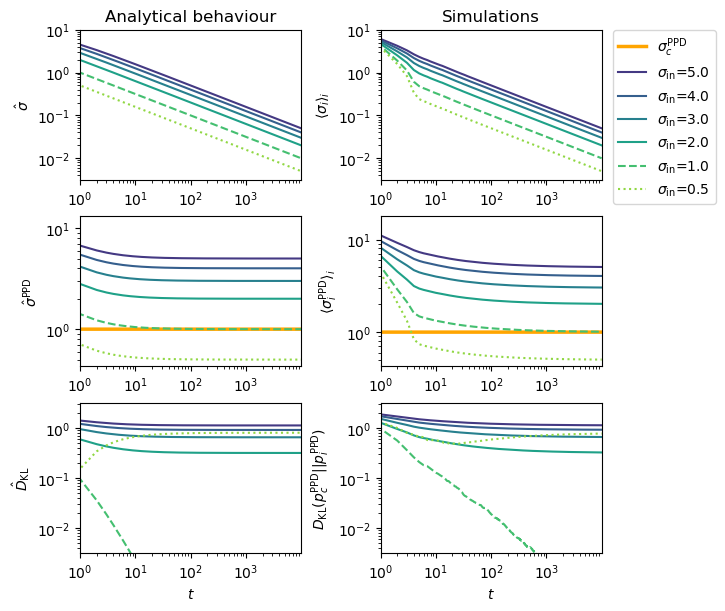

In [32]:
# Try plotting simulations next to analytics
sd_arr = ds.sd_llf.values[::-1]  # Reverse to have line stacking match label stacking
sd0 = 10  # For analytical results, use the same prior as for simulations
sd_C = 1  # Central node PPD's sd
N = int(10**4)  # Also, use the same time span
time = np.arange(N)

# Plotting...
x = 2
y = 3
c = 2
fig, ax = plt.subplots(y, x, figsize=(1.5 * c * x, 1 * c * y))
colors = nop.get_colorcycle(N_colors=len(sd_arr))
for i, j in itertools.product(np.arange(y), np.arange(x)):
    ax[i, j].set_prop_cycle(color=colors)
    ax[i, j].set_xlim((time[1], time[-1]))
    ax[i, j].set_xscale("log")
    ax[i, j].set_yscale("log")

# Preparation: Add line to-be-modelled PPD sd (aka. sd_PPD=1); set colorcycles
for j in [0, 1]:
    label = "$\sigma^\\text{PPD}_{c}$"
    if j != 0:
        label = "_" + label
    ax[1, j].plot(time, np.ones(N) * sd_C, color="orange", lw=2.5, label=label)

# Plot analytical results...
j = 0

for sd_in in sd_arr:

    # sd_N(N)
    sd = sd_N(sd0, sd_in, time)
    ax[0, j].plot(
        sd,
        ls=get_ls(sd_in),
    )
    ax[0, j].set_ylabel("$\hat\sigma$")

    # sd_PPD(N)
    sd_PPD = (sd**2 + sd_in**2) ** 0.5
    ax[1, j].plot(
        sd_PPD,
        ls=get_ls(sd_in),
    )
    ax[1, j].set_ylabel("$\hat\sigma^\\text{PPD}$")

    # KLD_PPD(N), given same means and sd_P=1
    ax[2, j].plot(
        np.log(sd_PPD / sd_C) + sd_C**2 / (2 * sd_PPD**2) - 1 / 2,
        ls=get_ls(sd_in),
        label="$\sigma_\\text{in}$=" + str(sd_in),
    )
    ax[2, j].set_ylabel("$\hat D_\\text{KL}$")

# Data plots
j = 1
i = 0
for sd_llf in sd_arr:

    # <sd_i>
    i = 0
    ax[i, j].plot(
        time,
        (
            ds.sd.sel(N=1, nn=0, sd_llf=sd_llf, time=time, node=np.arange(N_nodes))
            - sd_llf
        ).mean(
            dim="node",
        ),
        ls=get_ls(sd_llf),
    )
    ax[i, j].set_ylabel("$\langle \sigma_i \\rangle_i$")

    # <sd_i>
    i = 1
    ax[i, j].plot(
        time,
        ds.sd.sel(N=1, nn=0, sd_llf=sd_llf, time=time, node=np.arange(N_nodes)).mean(
            dim="node"
        ),
        ls=get_ls(sd_llf),
    )
    ax[i, j].set_ylabel("$\langle \sigma^\\text{PPD}_i\\rangle_i$")

    # <D_KL(PPD_C||PPD_i)>
    i = 2
    ax[i, j].plot(
        time,
        ds.kld.sel(N=1, nn=0, sd_llf=sd_llf, time=time, node=np.arange(N_nodes)).mean(
            dim="node"
        ),
        ls=get_ls(sd_llf),
    )
    ax[i, j].set_ylabel("$D_\\text{KL}(p^\\text{PPD}_c||p^\\text{PPD}_i)$")

# Labelling & stuffs...
# Analytical
j = 0
ax[0, j].set_title("Analytical behaviour")
ax[y - 1, j].set_xlabel("$t$")
ax[0, j].set_ylim(10**-2.5, 10**1)
ax[y - 1, j].set_ylim(10**-2.5, 10**0.5)
# Simulations
j = 1
ax[0, j].set_title("Simulations")
ax[y - 1, j].set_xlabel("$t$")
ax[0, j].set_ylim(10**-2.5, 10**1)
ax[y - 1, j].set_ylim(10**-2.5, 10**0.5)

fig.legend(bbox_to_anchor=(1, 0.97), loc="upper left")

In [34]:
# fig.savefig("fig/@MA1-N1.pdf")

In [10]:
# Class-Consistency plot (reproduction)

# Define starting environment
nop.RANDOM_SEED = 112571560740682987948487733925061957463
mu_prior, sd_prior = 1, 100
mu_arr = np.linspace(-4, 4, 1000)
world_data = st.norm.rvs(loc=0, scale=1, size=5)

# Initiate nodes and samples
node_g = nop.NodeGridMu(
    node_id=0,
    log_priors=st.norm.logpdf(x=mu_arr, loc=mu_prior, scale=sd_prior),
)
node_c = nop.NodeConjMu(
    node_id=1,
    params_node=dict(loc=mu_prior, scale=sd_prior),
)

g_samples = []
for i, x in enumerate(world_data):
    node_g.set_updated_belief(st.norm, mu_arr, 1, x, -1, i)
    g_samples += [node_g.log_probs.copy()]
    node_c.set_updated_belief(x, -1, i)
g_samples = np.array(g_samples)

mu_p_arr, sd_p_arr = nop.postrun_Mu_ConjMu(mu_prior, sd_prior, 1, node_c.diary_in)
p_samples = np.zeros_like(g_samples)
for i, params in enumerate(zip(mu_p_arr, sd_p_arr)):
    p_samples[i] = st.norm.logpdf(mu_arr, loc=params[0], scale=params[1])

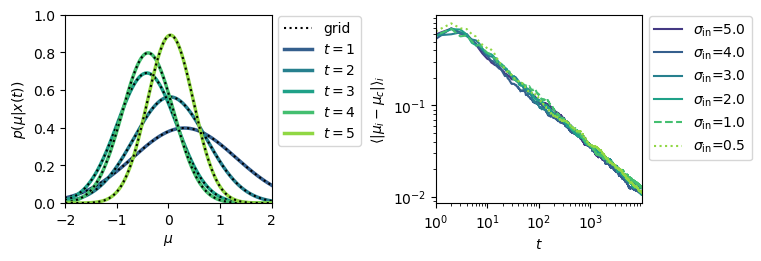

In [11]:
# Figure set-up
x, y = (2, 1)
c = 2.5
fig, ax = plt.subplots(y, x, figsize=(1.5 * c * x, 1 * c * y))

# ----------------------------------------------------------------------
# Class-consistency (from above cell)
cmap = nop.get_colorcycle(len(g_samples))

i = 0
ax[i].set_prop_cycle(
    color=nop.get_colorcycle(len(g_samples) + 1)[1:],
)
ax[i].plot(0, 0, c="black", lw=1.5, ls=":", label="grid")

for k, y in enumerate(zip(g_samples, p_samples)):
    ax[i].plot(mu_arr, np.exp(y[1]), lw=2.5, label=f"$t=${k+1}")
    ax[i].plot(
        mu_arr,
        np.exp(y[0]) * np.max(np.exp(y[1])),
        c="black",
        ls=":",
        lw=1.5,
    ),
ax[i].set_xlabel("$\mu$")
ax[i].set_ylabel("$p(\mu | x(t))$")
ax[i].set_xlim(-2, 2)
ax[i].set_ylim(0, 1)
ax[i].legend(loc=2, bbox_to_anchor=(1, 1.03))

# ----------------------------------------------------------------------
# <|mu_i-mu_c|>
# Params of interest
sd_arr = ds.sd_llf.values[::-1]
N = int(10**4)  # Also, use the same time span
time = np.arange(N)

# Plot prep.
i = 1
colors = nop.get_colorcycle(N_colors=len(sd_arr))
ax[i].set_prop_cycle(color=colors)
ax[i].set_xlim((time[1], time[-1]))
ax[i].set_xscale("log")
ax[i].set_yscale("log")

# Plotting...
for sd_llf in sd_arr:
    # <|mu_i-mu_C|>
    ax[i].plot(
        time,
        np.abs(
            ds.mu.sel(N=1, nn=0, sd_llf=sd_llf, time=time, node=np.arange(N_nodes))
        ).mean(
            dim="node",
        ),
        ls=get_ls(sd_llf),
        label="$\sigma_\\text{in}$=" + str(sd_llf),
    )

# Title, label, ...
ax[i].set_xlabel("$t$")
ax[i].set_ylabel("$\langle |\mu_i-\mu_c|\\rangle_i$")
ax[i].legend(bbox_to_anchor=(1, 1.03), loc=2)

In [12]:
# fig.savefig("./fig/N1-Consistency--Delta.pdf")

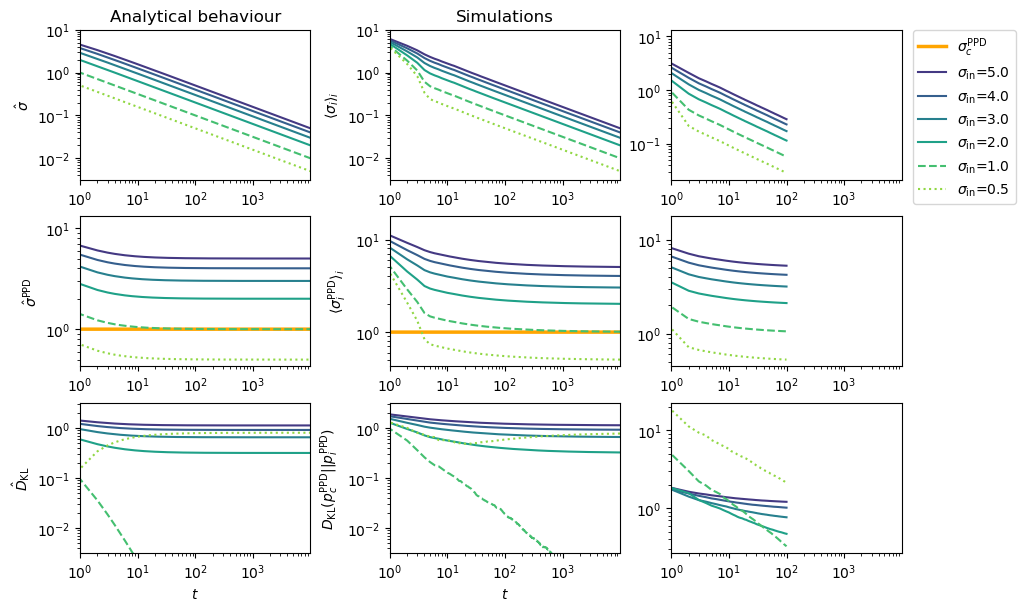

In [46]:
# Add N=2, nn=1 as if its 2020
sd_arr = ds.sd_llf.values[::-1]  # Reverse to have line stacking match label stacking
sd0 = 10  # For analytical results, use the same prior as for simulations
sd_C = 1  # Central node PPD's sd
N = int(10**4)  # Also, use the same time span
time = np.arange(N)
t2_len = len(get_kld(2, 1, sd_llf_arr[-1]))

# Figure set-up...
x = 3
y = 3
c = 2
fig, ax = plt.subplots(y, x, figsize=(1.5 * c * x, 1 * c * y))
colors = nop.get_colorcycle(N_colors=len(sd_arr))
for i, j in itertools.product(np.arange(y), np.arange(x)):
    ax[i, j].set_prop_cycle(color=colors)
    ax[i, j].set_xlim((time[1], time[-1]))
    ax[i, j].set_xscale("log")
    ax[i, j].set_yscale("log")

# Preparation: Add line to-be-modelled PPD sd (aka. sd_PPD=1); set colorcycles
for j in [0, 1]:
    label = "$\sigma^\\text{PPD}_{c}$"
    if j != 0:
        label = "_" + label
    ax[1, j].plot(time, np.ones(N) * sd_C, color="orange", lw=2.5, label=label)

# Plot analytical results...
j = 0
for sd_in in sd_arr:
    # sd_N(N)
    sd = sd_N(sd0, sd_in, time)
    ax[0, j].plot(
        sd,
        ls=get_ls(sd_in),
    )
    ax[0, j].set_ylabel("$\hat\sigma$")
    # sd_PPD(N)
    sd_PPD = (sd**2 + sd_in**2) ** 0.5
    ax[1, j].plot(
        sd_PPD,
        ls=get_ls(sd_in),
    )
    ax[1, j].set_ylabel("$\hat\sigma^\\text{PPD}$")
    # KLD_PPD(N), given same means and sd_P=1
    ax[2, j].plot(
        np.log(sd_PPD / sd_C) + sd_C**2 / (2 * sd_PPD**2) - 1 / 2,
        ls=get_ls(sd_in),
        label="$\sigma_\\text{in}$=" + str(sd_in),
    )
    ax[2, j].set_ylabel("$\hat D_\\text{KL}$")

# Data plots
# N=1, nn=0
j = 1
for sd_llf in sd_arr:
    # <sd_i>
    i = 0
    ax[i, j].plot(
        time,
        (
            ds.sd.sel(N=1, nn=0, sd_llf=sd_llf, time=time, node=np.arange(N_nodes))
            - sd_llf
        ).mean(
            dim="node",
        ),
        ls=get_ls(sd_llf),
    )
    ax[i, j].set_ylabel("$\langle \sigma_i \\rangle_i$")
    # <sd^PPD_i>
    i = 1
    ax[i, j].plot(
        time,
        ds.sd.sel(N=1, nn=0, sd_llf=sd_llf, time=time, node=np.arange(N_nodes)).mean(
            dim="node"
        ),
        ls=get_ls(sd_llf),
    )
    ax[i, j].set_ylabel("$\langle \sigma^\\text{PPD}_i\\rangle_i$")
    # <D_KL(PPD_C||PPD_i)>
    i = 2
    ax[i, j].plot(
        time,
        ds.kld.sel(N=1, nn=0, sd_llf=sd_llf, time=time, node=np.arange(N_nodes)).mean(
            dim="node"
        ),
        ls=get_ls(sd_llf),
    )
    ax[i, j].set_ylabel("$D_\\text{KL}(p^\\text{PPD}_c||p^\\text{PPD}_i)$")

# N=2, nn=1
j = 2
for sd_llf in sd_arr:
    # <sd_i>
    i = 0
    ax[i, j].plot(
        time[:t2_len],
        (
            ds.sd.sel(
                N=2, nn=1, sd_llf=sd_llf, time=time[:t2_len], node=np.arange(N_nodes)
            )
            - sd_llf
        ).mean(dim="node"),
        ls=get_ls(sd_llf),
    )
    # <sd^PPD_i>
    i = 1
    ax[i, j].plot(
        time[:t2_len],
        ds.sd.sel(
            N=2, nn=1, sd_llf=sd_llf, time=time[:t2_len], node=np.arange(N_nodes)
        ).mean(dim="node"),
        ls=get_ls(sd_llf),
    )
    # <KLD_i>
    i = 2
    ax[i, j].plot(
        time[:t2_len],
        ds.kld.sel(
            N=2, nn=1, sd_llf=sd_llf, time=time[:t2_len], node=np.arange(N_nodes)
        ).mean(dim="node"),
        ls=get_ls(sd_llf),
    )

# Labelling & stuffs...
# Analytical
j = 0
ax[0, j].set_title("Analytical behaviour")
ax[y - 1, j].set_xlabel("$t$")
ax[0, j].set_ylim(10**-2.5, 10**1)
ax[y - 1, j].set_ylim(10**-2.5, 10**0.5)
# Simulations
j = 1
ax[0, j].set_title("Simulations")
ax[y - 1, j].set_xlabel("$t$")
ax[0, j].set_ylim(10**-2.5, 10**1)
ax[y - 1, j].set_ylim(10**-2.5, 10**0.5)

fig.legend(bbox_to_anchor=(1, 0.97), loc="upper left")

In [37]:
len(ds.kld.sel(N=1, nn=0, sd_llf=sd_llf, node=np.arange(N_nodes)))

10001